In [120]:
import music21
from music21 import converter, instrument, note, chord, midi, stream
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint


# Parameters
Here are parameters you can edit in this script.

In [121]:
# Memory length -- each new note is generated by considering this many previous notes
sequence_length = 20

# How many rounds of training to perform -- more training will likely provide better performance
training_rounds = 20

# Where to ouput the generated file
output_file = "output.mid"

# Number of output notes to generate
numberOutputNotes = 200


### Preprocessing
First we must load the data from the songs. To do this, we'll go through all the songs in our training data of MIDI files. We parse them with music21 to get the individual notes. If the element is a chord, then it is converted to it's numerical representation. After this step we will have all of the notes/chords that appear in string form, and a corresponding vocabulary as a set of them all.

In [122]:
notes = []
track = 0

files = glob.glob("input*.mid")

for i, file in enumerate(files):
    midi = converter.parse(file)
    # There are multiple tracks in the MIDI file, so we'll use the first one
    midi = midi[track]
    notes_to_parse = None
        
    # Parse the midi file by the notes it contains
    notes_to_parse = midi.flat.notes
        
    for element in notes_to_parse:
        if isinstance(element, music21.note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            # get's the normal order (numerical representation) of the chord
            notes.append('.'.join(str(n) for n in element.normalOrder))
    print("Song {} Loaded".format(i+1))
                
print("DONE LOADING SONGS")    
# Get all pitch names
pitches = sorted(set(item for item in notes))
# Get all pitch names
vocab_length = len(pitches)  
number_notes = len(notes)
# print(vocab_length)
# print(notes)
# print(len(notes))
print(f'I found {number_notes} notes')


Song 1 Loaded
Song 2 Loaded
DONE LOADING SONGS
I found 3098 notes


In [123]:
assert len(notes) > sequence_length

Now we must get these notes in a usable form for our LSTM. Let's construct sequences that can be grouped together to predict the next note in groups of 10 notes.

In [125]:
# Let's use One Hot Encoding for each of the notes and create an array as such of sequences. 
#Let's first assign an index to each of the possible notes
note_dict = dict()
for i, note in enumerate(pitches):
    note_dict[note] = i
#print(note_dict)



# Lets make a numpy array with the number of training examples, sequence length, and the length of the one-hot-encoding
num_training = number_notes - sequence_length

input_notes = np.zeros((num_training, sequence_length, vocab_length))
output_notes = np.zeros((num_training, vocab_length))

for i in range(0, num_training):
    # Here, i is the training example, j is the note in the sequence for a specific training example
    input_sequence = notes[i: i+sequence_length]
    output_note = notes[i+sequence_length]
    for j, note in enumerate(input_sequence):
        input_notes[i][j][note_dict[note]] = 1
    output_notes[i][note_dict[output_note]] = 1

In [126]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, vocab_length)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(vocab_length))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

history = model.fit(input_notes, output_notes, batch_size=128, nb_epoch=training_rounds)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/20
3078/3078 [==============================] - 7s 2ms/step - loss: 4.4391 - acc: 0.0432
Epoch 2/20
3078/3078 [==============================] - 2s 709us/step - loss: 4.1670 - acc: 0.0497
Epoch 3/20
3078/3078 [==============================] - 2s 747us/step - loss: 4.1020 - acc: 0.0539
Epoch 4/20
3078/3078 [==============================] - 2s 712us/step - loss: 4.0055 - acc: 0.0588
Epoch 5/20
3078/3078 [==============================] - 2s 701us/step - loss: 3.9343 - acc: 0.0643
Epoch 6/20
3078/3078 [==============================] - 2s 698us/step - loss: 3.8660 - acc: 0.0692
Epoch 7/20
3078/3078 [==============================] - 2s 686us/step - loss: 3.7724 - acc: 0.0796
Epoch 8/20
3078/3078 [==============================] - 2s 720us/step - loss: 3.7150 - acc: 0.0900
Epoch 9/20
3078/3078 [==============================] - 2s 698us/step - loss: 3.6404 - acc: 0.0942
Epoch 10/20
3078/3078 [==============================] - 2s 701us/step - loss: 3.5697 - acc: 0.0988
Epoch 11/20

#### Visualizing the Model's Results
The models accuracy can be seen here increasing, as it learns the sequences over the course of 200 epochs.

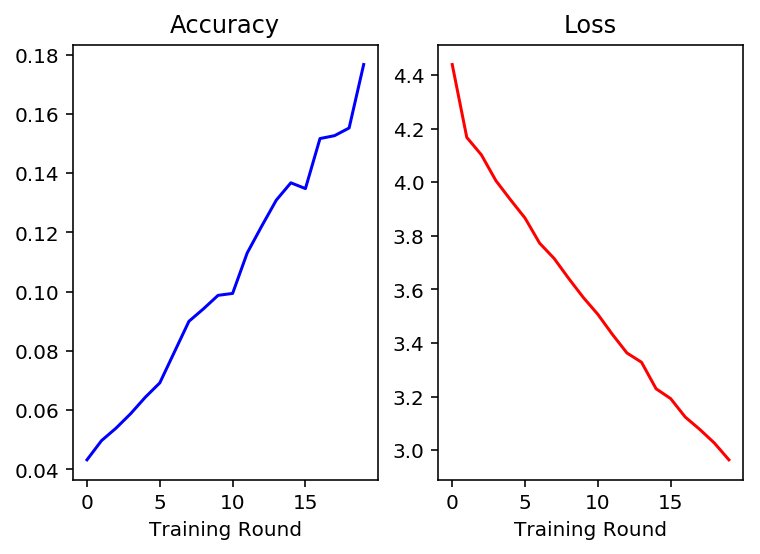

In [127]:
# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['acc'], color='b')
plt.title('Accuracy')
plt.xlabel('Training Round')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], color='r')
plt.title("Loss")
plt.xlabel('Training Round')
plt.show()

### Generating New Music

In [128]:
# Make a dictionary going backwards (with index as key and the note as the value)
backward_dict = dict()
for note in note_dict.keys():
    index = note_dict[note]
    backward_dict[index] = note

# pick a random sequence from the input as a starting point for the prediction
n = np.random.randint(0, len(input_notes)-1)
sequence = input_notes[n]
start_sequence = sequence.reshape(1, sequence_length, vocab_length)
output = []


# Generate song with numberOutputNotes notes
for i in range(0, numberOutputNotes):
    newNote = model.predict(start_sequence, verbose=0)
    # Get the position with the highest probability
    index = np.argmax(newNote)
    encoded_note = np.zeros((vocab_length))
    encoded_note[index] = 1
    output.append(encoded_note)
    sequence = start_sequence[0][1:]
    start_sequence = np.concatenate((sequence, encoded_note.reshape(1, vocab_length)))
    start_sequence = start_sequence.reshape(1, sequence_length, vocab_length)
    

# Now output is populated with notes in their string form
# for element in output:
#    print(element)

### Convert to MIDI format
Code here to output to MIDI files taken from github repo https://github.com/Skuldur/Classical-Piano-Composer.

In [129]:
finalNotes = [] 
for element in output:
    index = list(element).index(1)
    finalNotes.append(backward_dict[index])
    
offset = 0
output_notes = []
    
# create note and chord objects based on the values generated by the model
for pattern in finalNotes:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = music21.note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = music21.note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)

    # increase offset each iteration so that notes do not stack
    offset += 0.5

midi_stream = stream.Stream(output_notes)

midi_stream.write('midi', fp=output_file)
print(f"Done writing output file: {output_file}")

Done writing output file: output.mid
